In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from MITgcmutils import mds
from jmd95 import eos
from pygamman import gamman
import os

%matplotlib inline


In [2]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_matt'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


## data.diagnostics ##

    frequency(1) = 2629200.0,
    fields(1,1) = 'SIarea  ',
                 'SIheff  ',
                 'SIhsnow ',
                 'SItflux ',
                 'SIatmQnt',
                 'SIempmr ',
                 'SIatmFW ',
                 'SIuheff ',
                 'SIvheff ',
                 'TFLUX   ',
                 'SFLUX   ',
                 'THETA   ',
                 'SALT    ',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-monthly',




In [3]:
nrec = 0
new_ddir = '/data/scratch/rpa/SOSE/matt_iter100'


# 5 day output; want to sample different seasons
Nt = 438
# once every season for six years
recs = np.arange(0,Nt,18)

# just care about the long-term mean for b factor
gamma = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=recs, usememmap=True).mean(axis=0)
theta = mds.rdmds(os.path.join(new_ddir, 'THETA.0000000100'), rec=recs, usememmap=True).mean(axis=0)
salt = mds.rdmds(os.path.join(new_ddir, 'SALT.0000000100'), rec=recs, usememmap=True).mean(axis=0)

In [15]:
PHref = mds.rdmds(os.path.join(ddir,'PHrefC'))
pref = PHref.squeeze() / 9.81

In [115]:
rho = np.zeros_like(gamma)
drhodt = np.zeros_like(gamma)
drhods = np.zeros_like(gamma)
for k in range(m.Nz):
    rho_tmp, a, b = eos.state(pref[k], theta[k].ravel(), salt[k].ravel())
    rho[k] = rho_tmp.reshape((m.Ny, m.Nx))
    drhodt[k] = a.reshape((m.Ny, m.Nx))
    drhods[k] = b.reshape((m.Ny, m.Nx))

In [18]:
rho.shape = gamma.shape

# mask
gmask = (gamma<0) | m.mask
gamma_n = np.ma.masked_array(gamma,gmask)
rho = np.ma.masked_array(rho,gmask)

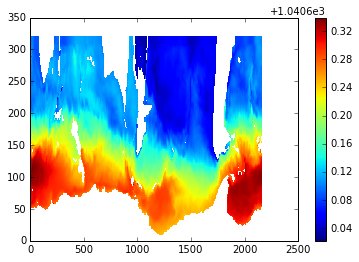

In [19]:
plt.pcolormesh(rho[30])
plt.colorbar()

In [20]:
print gamma_n.max()
print rho.max()

28.7226087952
1052.93631408


In [64]:
newmask = m.mask.copy()
newmask[1:-1] = m.mask[1:-1] | m.mask[2:] | m.mask[:-2]
newmask[0] = m.mask[0] | m.mask[1]
newmask[-1] = m.mask[-1] | m.mask[-2]

In [145]:
# calculate b factor
# b = |grad gamma| / |grad rho| ~= (drho / dz) / (dgam / dz) = drho / dgam

#drho = np.ma.masked_array(m.delta_k(rho, d=0), newmask)
#dgam = np.ma.masked_array(m.delta_k(gamma_n, d=0), newmask)
#dgam = np.zeros_like(gamma_n)

def z_deriv(rho):
    drho = np.zeros_like(rho)
    drho[1:-1] = (rho[:-2] - rho[2:]) / (m.drc[1:-1]+m.drc[2:])
    drho[0] = (rho[0] - rho[1]) / m.drc[1]
    drho[-1] = (rho[-2] - rho[-1]) / m.drc[-1]
    return np.ma.masked_array(drho, newmask)

drho = z_deriv(rho)
dgam = z_deriv(gamma_n)
dsig = (drhods * z_deriv(salt) + drhodt * z_deriv(theta))

b = np.ma.masked_outside(np.abs(dgam) / np.abs(dsig),0.1,10)

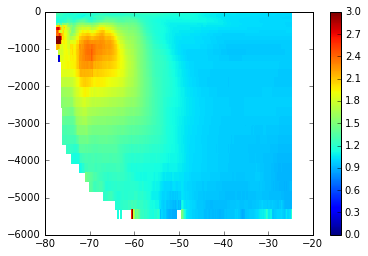

In [147]:
plt.pcolormesh(m.yc[0,:,0], m.zc.squeeze(), b.mean(axis=-1))
plt.clim(0,3)
plt.colorbar()

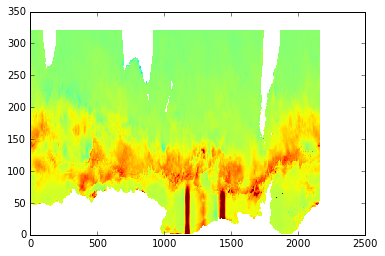

In [150]:
plt.pcolormesh(b[0])
plt.clim(0,2)

In [152]:
np.save('b_factor', b.filled(1.))